# TOC
PREP    
Importing libraries and data
Data prep for time series forecasting
   
FORECAST: MONTHLY DATA 
Data smoothing & analysis   

### PREP

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.style.use('bmh')

In [4]:
# Importing data

path = r'C:\Users\Ryzen RGB Madness!!!\Iowa Liquor Sales Analysis'

In [5]:
liquor_data_complete = pd.read_pickle(os.path.join(path, '01 - Data', 'Cleaned', 'iowa_sales_location_population.pkl'))

In [6]:
liquor_data_complete.shape

(12537543, 26)

In [7]:
# Data prep - setting date as index column

liquor_data_timedata = liquor_data_complete.set_index('date')

In [8]:
liquor_data_timedata.head()

,invoice_number,store_number,store_name,address,city,zip_code,latitude,longitude,county_fips,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
date,,,,,,,,,,,,,,,,,,,,,
2018-09-04,INV-14210900001,4617,LICKETY LIQUOR,2501 HUBBELL AVE,DES MOINES,50317,41.607739,-93.570182,19153,Polk,...,36904,MCCORMICK VODKA PET,24,375,1.80,2.70,48,129.60,18.0,4.75
2019-01-08,INV-16812800013,5151,IDA LIQUOR,500 HWY 175,IDA GROVE,51445,42.350164,-95.489235,19093,Ida,...,38176,TITOS HANDMADE VODKA,12,750,9.64,14.46,12,173.52,9.0,2.37
2019-03-12,INV-18087600031,5151,IDA LIQUOR,500 HWY 175,IDA GROVE,51445,42.350164,-95.489235,19093,Ida,...,27102,TEMPLETON 4YR RYE,6,750,18.09,27.14,6,162.84,4.5,1.18
2018-10-23,INV-15226900023,5151,IDA LIQUOR,500 HWY 175,IDA GROVE,51445,42.350164,-95.489235,19093,Ida,...,35918,FIVE O'CLOCK VODKA,6,1750,7.20,10.80,6,64.80,10.5,2.77
2019-02-01,INV-17301000008,2445,RUBACK'S FOOD CENTER,504 SOUTH HIGHWAY,OAKLAND,51560,41.309302,-95.396649,19155,Pottawattamie,...,36306,HAWKEYE VODKA,12,750,3.34,5.01,12,60.12,9.0,2.37


In [9]:
# Removing unnecessary columns for forecasting

liquor_data_td_dollars = liquor_data_timedata.drop(columns =['invoice_number', 'store_number', 'store_name', 'address', 'city',
       'zip_code', 'latitude', 'longitude', 'county_fips', 'county',
       'population', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'volume_sold_liters',
       'volume_sold_gallons'])

In [10]:
liquor_data_td_dollars.head()

,sale_dollars
date,
2018-09-04,129.60
2019-01-08,173.52
2019-03-12,162.84
2018-10-23,64.80
2019-02-01,60.12


In [11]:
liquor_data_grouped_month = liquor_data_td_dollars.groupby(by=pd.Grouper(level='date', freq='M', sort=True)).sum().reset_index() 
liquor_data_grouped_month.set_index(keys=['date'], drop=True, inplace=True)
liquor_data_grouped_month.head()

,sale_dollars
date,
2018-01-31,22606775.80
2018-02-28,22861176.42
2018-03-31,24873041.23
2018-04-30,26214746.69
2018-05-31,30180818.39


### FORECASTING

In [13]:
data = liquor_data_grouped_month

In [50]:
# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

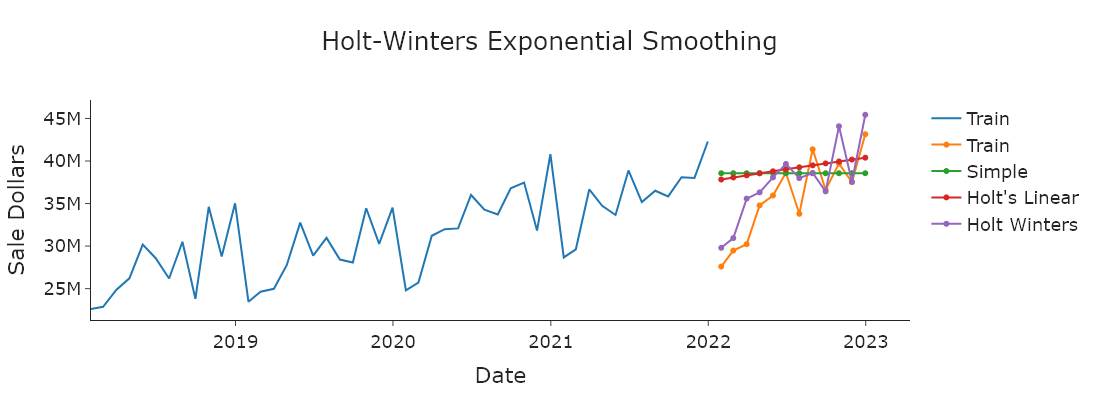

In [51]:
def plot_func(forecast1: list[float],
              forecast2: list[float],
              forecast3: list[float],
              title: str):
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['sale_dollars'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['sale_dollars'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index, y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Sale Dollars')
    return fig.show()

model_simple = SimpleExpSmoothing(train['sale_dollars']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

model_holt = Holt(train['sale_dollars'], damped_trend=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

model_holt_winters = ExponentialSmoothing(train['sale_dollars'], trend='mul',
                                          seasonal='mul', seasonal_periods=12)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))

plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  "Holt-Winters Exponential Smoothing")

In [31]:
print(model_holt_winters.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:             sale_dollars   No. Observations:                    48
Model:             ExponentialSmoothing   SSE                 172313113564175.000
Optimized:                         True   AIC                            1419.638
Trend:                   Multiplicative   BIC                            1449.578
Seasonal:                Multiplicative   AICC                           1443.225
Seasonal Periods:                    12   Date:                  Thu, 07 Dec 2023
Box-Cox:                          False   Time:                          19:03:59
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1464286                alpha                 True
smoothing_trend 

### SARIMA

In [63]:
# Looking at sales by year

liquor_data_grouped_year = liquor_data_td_dollars.groupby(by=pd.Grouper(level='date', freq='Y', sort=True)).sum().reset_index() 
liquor_data_grouped_year.set_index(keys=['date'], drop=True, inplace=True)
liquor_data_grouped_year.head()

,sale_dollars
date,
2018-12-31,3.342168e+08
2019-12-31,3.492203e+08
2020-12-31,3.966631e+08
2021-12-31,4.281235e+08
2022-12-31,4.287800e+08


In [58]:
# Dickey-Fuller test for stationarity

from statsmodels.tsa.stattools import adfuller

def ad_fuller(liquor_data_grouped_month):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(liquor_data_grouped_month, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(liquor_data_grouped_month['sale_dollars']))

Dickey-Fuller Test indicates:
Test Statistic                 -0.394517
p-value                         0.987043
#Lags Used                     11.000000
Number of Observations Used    48.000000
dtype: float64
None


ANALYSIS    
Given how high the p-score is here, the data is clearly not stationary. However, in the time series analysis, I only differenced the data one time, so I will set my d value to 1 for my SARIMA modeling.

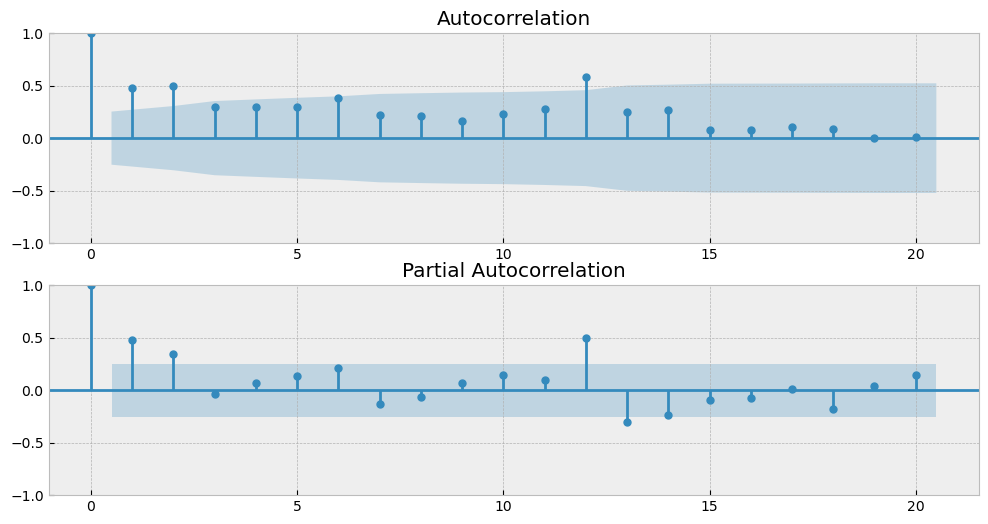

In [60]:
# Autocorrelation and partial autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(liquor_data_grouped_month.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(liquor_data_grouped_month.dropna(), ax=ax[1], lags=20)

ANALYSIS   
Because there's only the one sufficiently large high spike at the beginning, I'll be setting my q value to 1. 

In [61]:
model = sm.tsa.statespace.SARIMAX(liquor_data_grouped_month['sale_dollars'],
                         order=(2, 1, 1),
                         seasonal_order=(0, 1, 1, 12))
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sale_dollars   No. Observations:                   60
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -770.197
Date:                            Thu, 07 Dec 2023   AIC                           1550.394
Time:                                    19:35:01   BIC                           1559.645
Sample:                                01-31-2018   HQIC                          1553.875
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0814      0.166     -6.504      0.000      -1.407      -0.756
ar.L2         -0.2640      0.056   